In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random

# Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Softmax
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.5.0


# 유틸

In [ ]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [ ]:
def load_model(
    model_name: str, with_weights_path: Optional[str] = None
) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

In [ ]:
import os
base_gdrive_path = os.path.join("drive", "MyDrive", "deep learning example")

In [ ]:
result_path = os.path.join(base_gdrive_path, "results")

# Dataset

## 다운로드

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

In [ ]:
# cv2가 처리하지 못하는 파일 삭제

!rm -f images/Egyptian_Mau_177.jpg
!rm -f annotations/trimaps/Egyptian_Mau_177.jpg

!rm -f images/Egyptian_Mau_191.jpg
!rm -f annotations/trimaps/Egyptian_Mau_191.jpg

!rm -f images/Egyptian_Mau_139.jpg
!rm -f annotations/trimaps/Egyptian_Mau_139.jpg

!rm -f images/Egyptian_Mau_145.jpg
!rm -f annotations/trimaps/Egyptian_Mau_145.jpg

!rm -f images/Egyptian_Mau_167.jpg
!rm -f annotations/trimaps/Egyptian_Mau_167.jpg

!rm -f images/Abyssinian_34.jpg
!rm -f annotations/trimaps/Abyssinian_34.jpg

## 확인

In [ ]:
import cv2
import os

# 다양한 크기

mask = cv2.imread(os.path.join("annotations", "trimaps", "Abyssinian_2.png"))
print(mask.shape)

img = cv2.imread(os.path.join("images", "Abyssinian_2.jpg"))
print(img.shape)

resized_img = cv2.resize(img, (256, 256))
print(resized_img.shape)

# 이미지와 마스크가 서로 다른 파일 개수

print(len(os.listdir(os.path.join("annotations", "trimaps"))))
print(len(os.listdir(os.path.join("images"))))

# 이미지는 jpg, 마스크는 png.

len(list(filter(lambda el: el[-3:] == "png", os.listdir(os.path.join("annotations", "trimaps")))))

# 이미지는 color. 마스크는 grayscale.

(473, 600, 3)
(473, 600, 3)
(256, 256, 3)
14780
7384


14780

# U-Net

## 준비

In [ ]:
batch_size = 32
seed = 42

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# img_generator = ImageDataGenerator()
# img_generator.flow_from_directory(
#     ".", 
#     classes=["images"], 
#     target_size=(256, 256), 
#     batch_size=batch_size,
#     color_mode="grayscale",
#     interpolation="nearest",
#     class_mode=None,
#     shuffle=True,
#     seed=42)

# mask_generator = ImageDataGenerator()
# mask_generator.flow_from_directory(
#     "annotations", 
#     classes=["trimaps"], 
#     target_size=(256, 256), 
#     batch_size=batch_size,
#     color_mode="grayscale",
#     interpolation="nearest",
#     class_mode=None,
#     shuffle=True,
#     seed=42)

## Generator 만들기

### Generator 생성

In [ ]:
image_files = os.listdir("images")
image_names = list(map(lambda v: v[:-4], image_files))

random.seed(seed)
random.shuffle(image_names)

split = int(0.95 * len(image_names))
train_image_names = image_names[0:split]
test_image_names  = image_names[split:]

val_split = int(0.9 * len(train_image_names))
val_image_names = train_image_names[val_split:]
train_image_names = train_image_names[0:val_split]

In [ ]:
import toolz
import numpy as np

def img_mask_generator(img_path, mask_path, image_files, mask_files, batch_size=1, target_size=(256, 256)):
  total_file_num = len(image_files)
  index = -1
  while True:
    index = 0 if index > ((total_file_num // batch_size) - 2) else index+1
    img_batch = []
    mask_batch = []
    
    for i in range(batch_size):
      img = cv2.imread(os.path.join(img_path, image_files[batch_size*index+i]), cv2.IMREAD_COLOR)
      img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)

      img = img / 255.

      img_batch.append(img)
      
      mask = cv2.imread(os.path.join(mask_path, mask_files[batch_size*index+i]), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

      mask[mask >= 2] = 0
      mask[mask != 0] = 1
      
      mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
      mask_batch.append(mask)

    yield np.array(img_batch), np.array(mask_batch)

with_ext = lambda v, ext: "{}.{}".format(v, ext)

In [ ]:
train_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

val_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

test_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

### 샘플 이미지 플롯

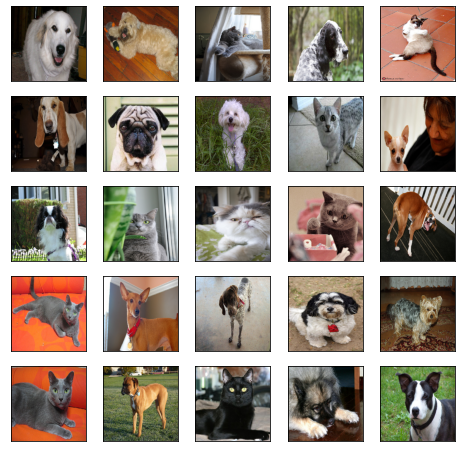

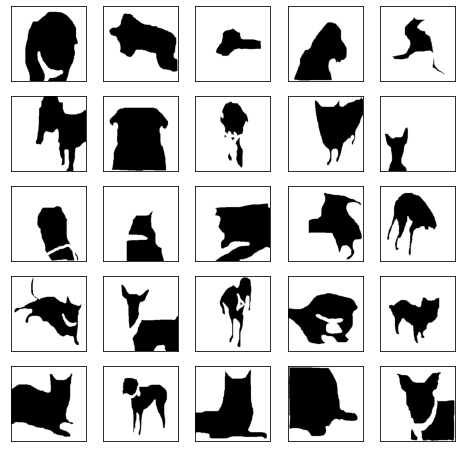

In [ ]:
plt.figure(figsize=(8, 8))

img_mask_batch = next(train_batch_generator)

for i in range(25):
  _img = np.float32(img_mask_batch[0][i])
  _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(_img, cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(8, 8))

for i in range(25):
  _mask = np.reshape(img_mask_batch[1][i], (256, 256))

  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(_mask, cmap=plt.cm.binary)
plt.show()


### Generator 초기화

In [ ]:
train_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

val_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

test_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

## 모델

### 모델 생성

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
# 원본 U-Net 논문 구현이지만, 메모리가 너무 많이 든다.
def vanilla_unet(sz=(256, 256, 3)):
  base_num_filter = 64

  input = Input(sz)
  
  # Encoding
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(input)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  skip1 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  skip2 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  skip3 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  skip4 = x

  x = MaxPooling2D()(x)

  # BottleNeck
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip4])
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip3])
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip2])
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip1])
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  
  output = Conv2D(1, 1, activation='sigmoid')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [ ]:
# 깊이를 줄인 U-Net

def unet(sz=(256, 256, 3)):
  base_num_filter = 64

  input = Input(sz)
  
  # Encoding
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(input)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  skip1 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  skip2 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  skip3 = x

  x = MaxPooling2D()(x)

  # BottleNeck
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip3])
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip2])
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip1])
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  
  output = Conv2D(1, 1, activation='softmax')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [ ]:
# 약간 변형된 U-Net 1
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  # down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  
  ff2 = 64 
  # bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  # upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  # classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  # model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

In [ ]:
# 약간 변형된 U-Net 2
def unet(sz=(256, 256, 3)):
  base_num_filter = 8

  input = Input(sz)
  
  # Encoding
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(input)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  skip1 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  skip2 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  skip3 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  skip4 = x

  x = MaxPooling2D()(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  skip5 = x

  x = MaxPooling2D()(x)
  
  # BottleNeck
  x = Conv2D(base_num_filter*32, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*32, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip5])
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip4])
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*8, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip3])
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*4, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip2])
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*2, 3, activation='relu', padding='same')(x)
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)

  x = Concatenate()([x, skip1])
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter, 3, activation='relu', padding='same')(x)
  
  output = Conv2D(1, 1, activation='sigmoid')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [ ]:
def encoding_conv(_input, _base_num_filter, _kernel=3, pooling=True):
    if pooling:
        x = MaxPooling2D()(_input)
    else:
        x = _input
    x = Conv2D(_base_num_filter, _kernel, activation='relu', padding='same')(x)
    x = Conv2D(_base_num_filter, _kernel, activation='relu', padding='same')(x)
    return x

def decoding_conv(_inputs, _base_num_filter, _kernel=3, up_sample=True):
    x = Concatenate()(_inputs)
    x = Conv2D(_base_num_filter, _kernel, activation='relu', padding='same')(x)
    x = Conv2D(_base_num_filter, _kernel, activation='relu', padding='same')(x)
    if up_sample:
        x = UpSampling2D()(x)
        x = Conv2D(_base_num_filter//2, _kernel, activation='relu', padding='same')(x)
    return x

# 약간 변형된 U-Net 3
def unet(sz=(256, 256, 3)):
  base_num_filter = 8

  input = Input(sz)
  
  # Encoding
  x = encoding_conv(input, base_num_filter, 3, False)
  skip1 = x
  x = encoding_conv(x, base_num_filter*2, 3, True)
  skip2 = x
  x = encoding_conv(x, base_num_filter*4, 3, True)
  skip3 = x
  x = encoding_conv(x, base_num_filter*8, 3, True)
  skip4 = x
  x = encoding_conv(x, base_num_filter*16, 3, True)
  skip5 = x

  x = MaxPooling2D()(x)
  
  # BottleNeck
  x = Conv2D(base_num_filter*32, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*32, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)

  x = decoding_conv([x, skip5], base_num_filter*16, 3, True)
  x = decoding_conv([x, skip4], base_num_filter*8, 3, True)
  x = decoding_conv([x, skip3], base_num_filter*4, 3, True)
  x = decoding_conv([x, skip2], base_num_filter*2, 3, True)
  x = decoding_conv([x, skip1], base_num_filter, 3, False)
  
  output = Conv2D(1, 1, activation='sigmoid')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [ ]:
class EConv2D(tf.keras.layers.Layer):
    def __init__(self, num_filter, kernel_size, pooling=True):
        super(EConv2D, self).__init__()
        self.num_filter = num_filter
        self.kernel_size = kernel_size
        self.pooling = pooling

    def build(self, input_shape):
        self.conv1 = Conv2D(self.num_filter, self.kernel_size, activation='relu', padding='same')
        self.conv2 = Conv2D(self.num_filter, self.kernel_size, activation='relu', padding='same')

    def call(self, input):
        if self.pooling:
            x = MaxPooling2D()(input)
        else:
            x = input
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class DConv2D(tf.keras.layers.Layer):
    def __init__(self, num_filter, kernel_size, up_sample=True):
        super(DConv2D, self).__init__()
        self.num_filter = num_filter
        self.kernel_size = kernel_size
        self.up_sample = up_sample

    def build(self, input_shape):
        self.conv1 = Conv2D(self.num_filter, self.kernel_size, activation='relu', padding='same')
        self.conv2 = Conv2D(self.num_filter, self.kernel_size, activation='relu', padding='same')
        self.conv3 = Conv2D(self.num_filter//2, self.kernel_size, activation='relu', padding='same')

    def call(self, inputs):
        x = Concatenate()(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        if self.up_sample:
            x = UpSampling2D()(x)
            x = self.conv3(x)
        return x

# 약간 변형된 U-Net 3
def unet(sz=(256, 256, 3)):
  base_num_filter = 8

  input = Input(sz)
  
  # Encoding
  x = EConv2D(base_num_filter, 3, False)(input)
  skip1 = x
  x = EConv2D(base_num_filter*2, 3, True)(x)
  skip2 = x
  x = EConv2D(base_num_filter*4, 3, True)(x)
  skip3 = x
  x = EConv2D(base_num_filter*8, 3, True)(x)
  skip4 = x
  x = EConv2D(base_num_filter*16, 3, True)(x)
  skip5 = x

  x = MaxPooling2D()(x)
  
  # BottleNeck
  x = Conv2D(base_num_filter*32, 3, activation='relu', padding='same')(x)
  x = Conv2D(base_num_filter*32, 3, activation='relu', padding='same')(x)
  
  # Decoding
  x = UpSampling2D()(x)
  x = Conv2D(base_num_filter*16, 3, activation='relu', padding='same')(x)

  x = DConv2D(base_num_filter*16, 3, True)([x, skip5])
  x = DConv2D(base_num_filter*8, 3, True)([x, skip4])
  x = DConv2D(base_num_filter*4, 3, True)([x, skip3])
  x = DConv2D(base_num_filter*2, 3, True)([x, skip2])
  x = DConv2D(base_num_filter, 3, False)([x, skip1])
  
  output = Conv2D(1, 1, activation='sigmoid')(x)
  
  # model creation
  model = Model(inputs=[input], outputs=[output])
  
  return model

In [ ]:
model = unet()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = [mean_iou])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 256, 256, 8)  224         input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 256, 256, 8)  584         conv2d_207[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_38 (MaxPooling2D) (None, 128, 128, 8)  0           conv2d_208[0][0]                 
____________________________________________________________________________________________

### 모델 트레이닝

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

val_image_list = list(map(lambda v: with_ext(v, "jpg"), val_image_names))

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        # print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        # choose a random test image and preprocess
        path = np.random.choice(val_image_list)
        img = cv2.imread(f'images/{path}')
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
        img = img / 255.

        target_mask = cv2.imread(os.path.join("annotations", "trimaps", "{}.png".format(path[:-4])))
        target_mask = cv2.resize(target_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        target_mask[target_mask >= 2] = 0
        target_mask[target_mask != 0] = 1
        
        # predict the mask 
        pred = model.predict(np.expand_dims(img, 0))
        
        # mask post-processing 
        msk = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        # show the mask and the segmented image 
        img = img.astype(np.float32) 
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        combined = np.concatenate([rgb_img, msk, rgb_img * msk, target_mask], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

Epoch 1/10
197/197 [==============================] - 120s 260ms/step - loss: 5.1307 - mean_iou: 0.0261 - val_loss: 0.5670 - val_mean_iou: 0.0000e+00


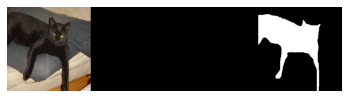

Epoch 2/10
197/197 [==============================] - 51s 258ms/step - loss: 0.4814 - mean_iou: 0.3606 - val_loss: 0.4573 - val_mean_iou: 0.4389


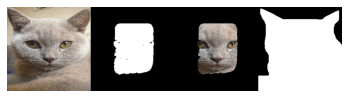

Epoch 3/10
197/197 [==============================] - 51s 258ms/step - loss: 0.4463 - mean_iou: 0.4407 - val_loss: 0.4394 - val_mean_iou: 0.4610


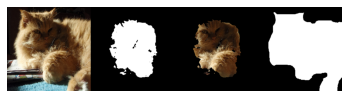

Epoch 4/10
197/197 [==============================] - 50s 256ms/step - loss: 0.4185 - mean_iou: 0.4848 - val_loss: 0.4065 - val_mean_iou: 0.5072


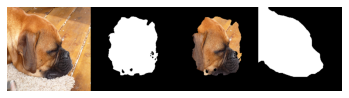

Epoch 5/10
197/197 [==============================] - 51s 259ms/step - loss: 0.3862 - mean_iou: 0.5297 - val_loss: 0.3358 - val_mean_iou: 0.5909


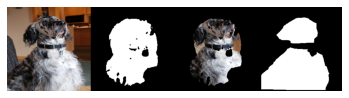

Epoch 6/10
197/197 [==============================] - 52s 263ms/step - loss: 0.3475 - mean_iou: 0.5814 - val_loss: 0.3128 - val_mean_iou: 0.6153


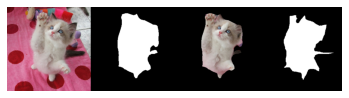

Epoch 7/10
197/197 [==============================] - 51s 261ms/step - loss: 0.3197 - mean_iou: 0.6162 - val_loss: 0.2910 - val_mean_iou: 0.6309


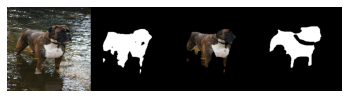

Epoch 8/10
197/197 [==============================] - 51s 259ms/step - loss: 0.2963 - mean_iou: 0.6492 - val_loss: 0.2513 - val_mean_iou: 0.6915


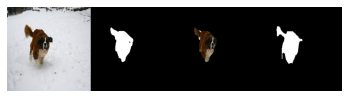

Epoch 9/10
197/197 [==============================] - 51s 258ms/step - loss: 0.2771 - mean_iou: 0.6707 - val_loss: 0.2454 - val_mean_iou: 0.6964


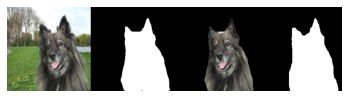

Epoch 10/10
197/197 [==============================] - 51s 259ms/step - loss: 0.2593 - mean_iou: 0.6948 - val_loss: 0.2404 - val_mean_iou: 0.7025


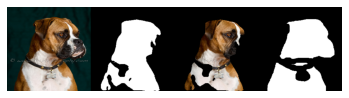

In [ ]:
train_steps = len(train_image_names) // batch_size
val_steps = len(val_image_names) // batch_size

history = model.fit(
    train_batch_generator,
    epochs = 10,
    steps_per_epoch = train_steps,
    validation_data = val_batch_generator, 
    validation_steps = val_steps,
    callbacks = build_callbacks(), 
    verbose = 1)

[0.02609592117369175, 0.36056235432624817, 0.4407486021518707, 0.48483777046203613, 0.529731810092926, 0.581396222114563, 0.6162221431732178, 0.6492360830307007, 0.6707288026809692, 0.6947608590126038]
[0.0, 0.4388708770275116, 0.46103331446647644, 0.5071607232093811, 0.5908549427986145, 0.6152669191360474, 0.6309158205986023, 0.6915110349655151, 0.696399986743927, 0.7025402784347534]


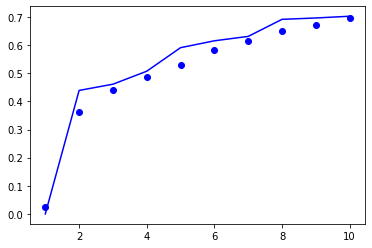

In [ ]:
history_accuracy = history.history["mean_iou"]
history_val_accuracy = history.history["val_mean_iou"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")

print(history_accuracy)
print(history_val_accuracy)

[5.130657196044922, 0.48144829273223877, 0.4462633430957794, 0.41846293210983276, 0.3861728310585022, 0.3474508225917816, 0.31968915462493896, 0.29628127813339233, 0.2770942747592926, 0.2593349814414978]
[0.5669954419136047, 0.4573129117488861, 0.43943023681640625, 0.40647634863853455, 0.33582428097724915, 0.3127999007701874, 0.29096370935440063, 0.2513309419155121, 0.24544604122638702, 0.24039551615715027]


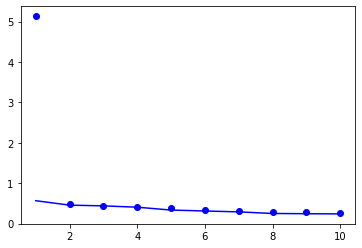

In [ ]:
history_loss = history.history["loss"]
history_val_loss = history.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")

print(history_loss)
print(history_val_loss)

### 모델 테스트 및 예측

In [ ]:
test_steps = len(test_image_names) // batch_size
test_loss, test_acc = model.evaluate(test_batch_generator, steps=test_steps, verbose=2)
print('테스트 정확도:', test_acc)

11/11 - 3s - loss: 0.2554 - mean_iou: 0.6974
테스트 정확도: 0.6974456310272217


In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2021-07-06 06:36:01--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 99.84.206.115, 99.84.206.48, 99.84.206.123, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|99.84.206.115|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.007s  

2021-07-06 06:36:01 (8.88 MB/s) - ‘test.jpg’ saved [63219/63219]



In [ ]:
import cv2
img = cv2.imread('test.jpg')
img.shape

(720, 720, 3)

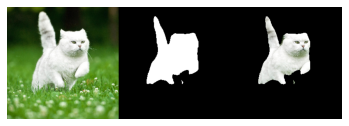

In [ ]:
img = cv2.imread('test.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# predict the mask 
pred = model.predict(np.expand_dims(img, 0))

# mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

### 모델 저장

In [ ]:
save_model(os.path.join(result_path, "unet_000.json"), model)

run_id: str = "001"
weight_file_name = "unet_000__{}.hdf5".format(run_id)

model.save_weights(os.path.join(result_path, weight_file_name))

In [ ]:
json_model_path = os.path.join(result_path, "unet_000.json")
model_weight_path = os.path.join(result_path, weight_file_name)
loaded_model2_with_weight = load_model(json_model_path, model_weight_path)

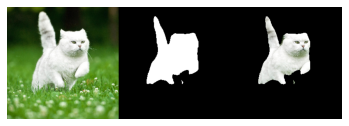

In [ ]:
img = cv2.imread('test.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# predict the mask 
pred = loaded_model2_with_weight.predict(np.expand_dims(img, 0))

# mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()